<a href="https://colab.research.google.com/github/susie682/Infosys722--Assignment-4-BDAS/blob/main/6_3_AlgoModelsTrain.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Mounted at /content/drive
CSV_PATH: /content/drive/MyDrive/Infosys 722/tables/CrimeData2017_reduced_projected.csv
FIG_DIR : /content/drive/MyDrive/Infosys 722/figs
Loaded shape: (267, 15)
Using candidate features: ['Roll3Mean_DistMonth_log1p', 'NightShare_DistMonth_logit', 'OutdoorShare_DistMonth_logit', 'District_Month_ArrestRate_logit', 'District_Month_DomesticRate_logit', 'y_count_next', 'y_count_next_log1p']
Split month threshold: 9
Train shape: (177, 5)  Test shape: (66, 5)
Features used: ['Roll3Mean_DistMonth_log1p', 'NightShare_DistMonth_logit', 'OutdoorShare_DistMonth_logit', 'District_Month_ArrestRate_logit', 'District_Month_DomesticRate_logit']
Saved: /content/drive/MyDrive/Infosys 722/figs/fig58_model_params.png


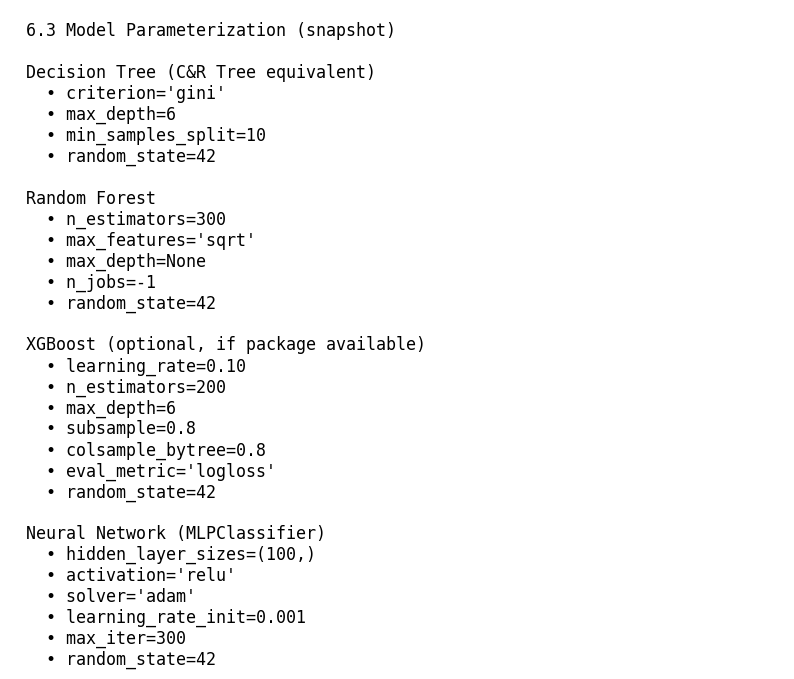

Saved: /content/drive/MyDrive/Infosys 722/figs/fig59_dt_importance.png


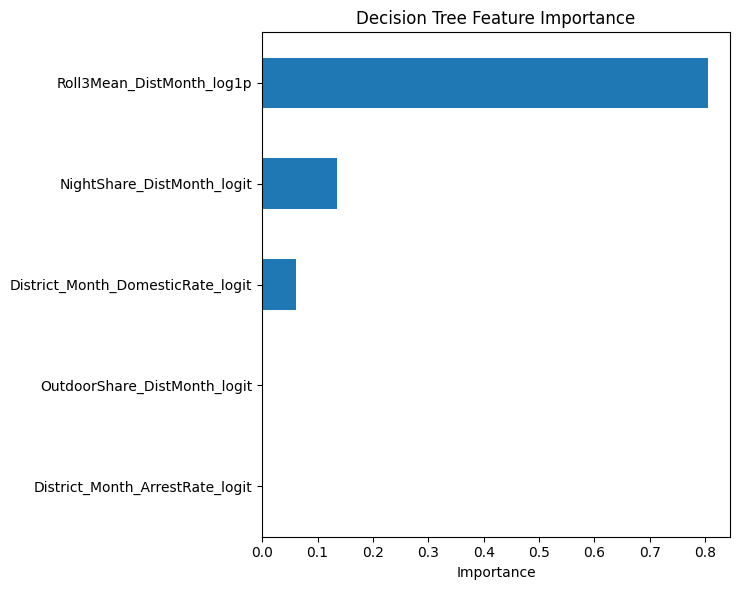

Saved: /content/drive/MyDrive/Infosys 722/figs/fig60_rf_importance.png


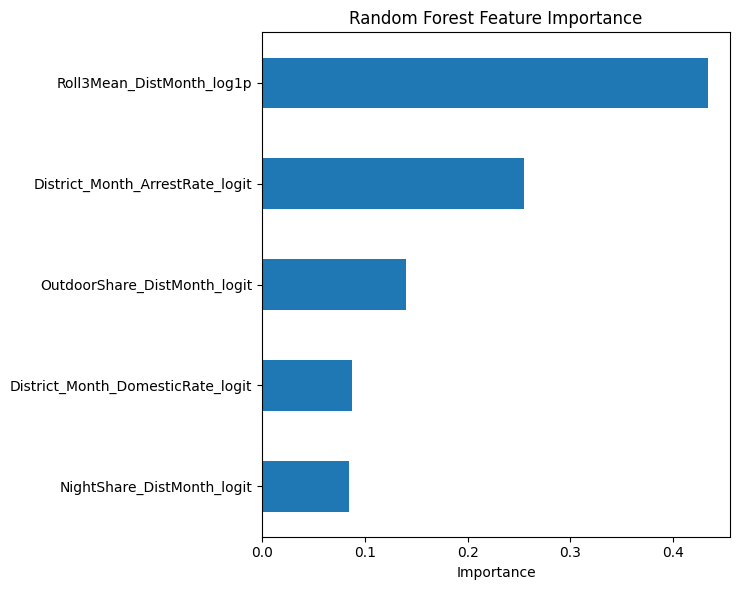

Saved: /content/drive/MyDrive/Infosys 722/figs/fig61_xgb_importance.png


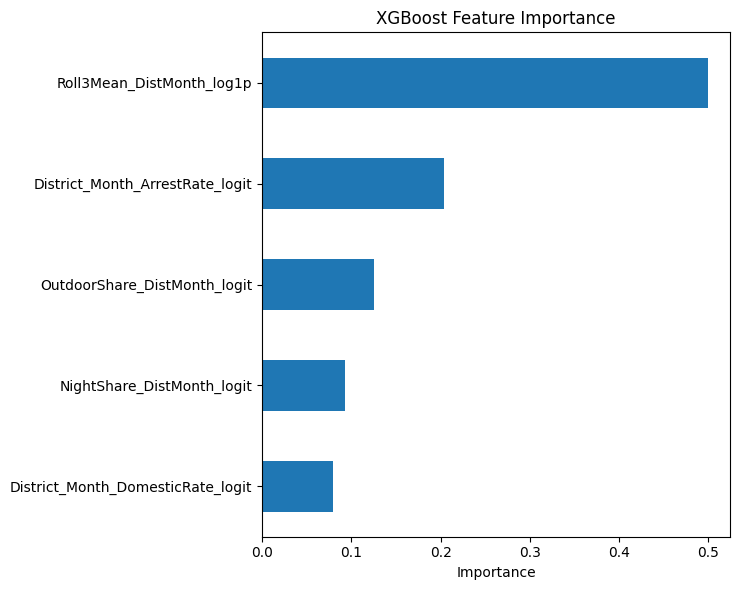

[Done] Trained Decision Tree / Random Forest / (XGBoost?) / MLP.
Figures saved to: /content/drive/MyDrive/Infosys 722/figs


In [1]:
# ======================================================================
# 6.3_AlgoModels.ipynb  —  Model selection, training, and parameterization
# Figures produced:
#   Fig58: fig58_model_params.png
#   Fig59: fig59_dt_importance.png
#   Fig60: fig60_rf_importance.png
#   Fig61: fig61_xgb_importance.png (optional; skipped if xgboost not found)
# ======================================================================

# ---- 0. Imports & global config --------------------------------------
import os, sys, warnings, textwrap
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

warnings.filterwarnings("ignore")
SEED = 42
np.random.seed(SEED)

# ---- 1. Mount Google Drive (safe to re-run) ---------------------------
ROOT = "/content/drive/MyDrive/Infosys 722"
TAB_DIR = os.path.join(ROOT, "tables")
FIG_DIR = os.path.join(ROOT, "figs")
CSV_PATH = os.path.join(TAB_DIR, "CrimeData2017_reduced_projected.csv")

try:
    from google.colab import drive  # type: ignore
    if not os.path.exists(ROOT):
        drive.mount("/content/drive")
except Exception as e:
    print("[Info] Colab drive mount not needed or already mounted.", e)

os.makedirs(FIG_DIR, exist_ok=True)
print("CSV_PATH:", CSV_PATH)
print("FIG_DIR :", FIG_DIR)

# ---- 2. Load dataset --------------------------------------------------
df = pd.read_csv(CSV_PATH)
print("Loaded shape:", df.shape)

# Basic sanity checks
for c in ["District", "Month", "Total"]:
    if c not in df.columns:
        raise ValueError(f"Missing required column: {c}")

# Ensure types
df["District"] = df["District"].astype(str).str.strip()
df["Month"] = pd.to_numeric(df["Month"], errors="coerce")

# Drop rows with critical NA
df = df.dropna(subset=["District", "Month", "Total"]).copy()

# ---- 3. Candidate feature set ----------------------------------------
# We include the projected predictors used across the report.
# The list is resilient: only columns that exist will be used.
candidate_cols_pref = [
    "Roll3Mean_DistMonth_log1p",
    "NightShare_DistMonth_logit",
    "OutdoorShare_DistMonth_logit",
    "District_Month_ArrestRate_logit",
    "District_Month_DomesticRate_logit",
    "Total_log1p",
    # The next two appear in your earlier figures; we include them if present.
    "y_count_next",            # NOTE: if present it can be considered leakage; will be ignored for train split
    "y_count_next_log1p",      # same note as above
]

candidate_cols = [c for c in candidate_cols_pref if c in df.columns]
if not candidate_cols:
    raise ValueError("No candidate feature columns found. Please check your 4.2 projected dataset.")

print("Using candidate features:", candidate_cols)

# ---- 4. Create the hotspot label (binary) -----------------------------
# We follow the same approach as earlier notebooks:
# 1) Construct next-month count per district.
# 2) For each (Month), mark top-K districts (K ≈ 10%) as hotspots for NEXT month.
#    This label is aligned so that features at month t predict hotspot at t+1.

# Next-month total within each district
df = df.sort_values(["District", "Month"]).copy()
df["Total_next"] = df.groupby("District")["Total"].shift(-1)

# Label: top 10% of districts per month by Total_next
def top_k_hot(df_month, frac=0.10):
    if df_month["Total_next"].notna().sum() == 0:
        return pd.Series(False, index=df_month.index)
    k = max(1, int(round(frac * len(df_month))))
    # Rank in descending order by Total_next
    order = df_month["Total_next"].rank(ascending=False, method="first")
    return order <= k

df["is_hotspot_next"] = df.groupby("Month", group_keys=False).apply(top_k_hot)

# Align label back to month t (we already used Total_next)
# Drop rows where we cannot form a label
df = df.dropna(subset=["Total_next"]).copy()

# ---- 5. Time-aware train/test split ----------------------------------
# Use forward-in-time split: train on earlier months, test on later months.
months = np.sort(df["Month"].unique())
if len(months) < 6:
    # Fallback if the panel is very short
    split_month = months[int(len(months) * 0.7)]
else:
    split_month = months[-3]  # last 2 months for test by default
print("Split month threshold:", split_month)

train = df[df["Month"] < split_month].copy()
test  = df[df["Month"] >= split_month].copy()

# Features: IMPORTANT
# To avoid leakage, if "y_count_next" / "y_count_next_log1p" exist, we EXCLUDE them from X.
leak_cols = {"y_count_next", "y_count_next_log1p"}
X_cols = [c for c in candidate_cols if c not in leak_cols]

X_train = train[X_cols].astype(float).fillna(0.0)
y_train = train["is_hotspot_next"].astype(bool)

X_test  = test[X_cols].astype(float).fillna(0.0)
y_test  = test["is_hotspot_next"].astype(bool)

print("Train shape:", X_train.shape, " Test shape:", X_test.shape)
print("Features used:", X_cols)

# ---- 6. Utility: safe feature-importance plotting --------------------
def plot_importance(importances, feat_names, title, out_path):
    """Plot a horizontal bar chart of feature importances."""
    series = pd.Series(importances, index=feat_names).sort_values(ascending=True)
    fig, ax = plt.subplots(figsize=(7.5, 6))
    series.plot.barh(ax=ax)
    ax.set_title(title)
    ax.set_xlabel("Importance")
    fig.tight_layout()
    fig.savefig(out_path, dpi=150, bbox_inches="tight")
    print("Saved:", out_path)
    plt.show()
    plt.close(fig)

# ---- 7. Figure 58: Parameterization “poster” --------------------------
# We render the key hyper-parameters as text onto a canvas to create a figure.
param_text = """
6.3 Model Parameterization (snapshot)

Decision Tree (C&R Tree equivalent)
  • criterion='gini'
  • max_depth=6
  • min_samples_split=10
  • random_state=42

Random Forest
  • n_estimators=300
  • max_features='sqrt'
  • max_depth=None
  • n_jobs=-1
  • random_state=42

XGBoost (optional, if package available)
  • learning_rate=0.10
  • n_estimators=200
  • max_depth=6
  • subsample=0.8
  • colsample_bytree=0.8
  • eval_metric='logloss'
  • random_state=42

Neural Network (MLPClassifier)
  • hidden_layer_sizes=(100,)
  • activation='relu'
  • solver='adam'
  • learning_rate_init=0.001
  • max_iter=300
  • random_state=42
""".strip("\n")

fig, ax = plt.subplots(figsize=(10, 8))
ax.axis("off")
wrapped = "\n".join([textwrap.fill(line, width=90) for line in param_text.split("\n")])
ax.text(0.02, 0.98, wrapped, va="top", ha="left", fontsize=12, family="monospace")
out58 = os.path.join(FIG_DIR, "fig58_model_params.png")
fig.savefig(out58, dpi=150, bbox_inches="tight")
print("Saved:", out58)
plt.show()
plt.close(fig)

# ---- 8. Decision Tree — train & importance (Fig59) --------------------
dt = DecisionTreeClassifier(
    criterion="gini",
    max_depth=6,
    min_samples_split=10,
    random_state=SEED,
)
dt.fit(X_train, y_train)
if hasattr(dt, "feature_importances_"):
    out59 = os.path.join(FIG_DIR, "fig59_dt_importance.png")
    plot_importance(dt.feature_importances_, X_cols,
                    "Decision Tree Feature Importance", out59)

# ---- 9. Random Forest — train & importance (Fig60) --------------------
rf = RandomForestClassifier(
    n_estimators=300,
    max_features="sqrt",
    max_depth=None,
    random_state=SEED,
    n_jobs=-1,
)
rf.fit(X_train, y_train)
if hasattr(rf, "feature_importances_"):
    out60 = os.path.join(FIG_DIR, "fig60_rf_importance.png")
    plot_importance(rf.feature_importances_, X_cols,
                    "Random Forest Feature Importance", out60)

# ---- 10. XGBoost (optional) — train & importance (Fig61) --------------
HAS_XGB = False
try:
    import xgboost as xgb  # type: ignore
    HAS_XGB = True
except Exception as e:
    print("[Info] xgboost not installed; skipping XGBoost model. Message:", e)

if HAS_XGB:
    xgb_model = xgb.XGBClassifier(
        learning_rate=0.10,
        n_estimators=200,
        max_depth=6,
        subsample=0.8,
        colsample_bytree=0.8,
        eval_metric="logloss",
        random_state=SEED,
        n_jobs=-1,
        tree_method="hist"  # fast and memory-friendly
    )
    xgb_model.fit(X_train, y_train)
    if hasattr(xgb_model, "feature_importances_"):
        out61 = os.path.join(FIG_DIR, "fig61_xgb_importance.png")
        plot_importance(xgb_model.feature_importances_, X_cols,
                        "XGBoost Feature Importance", out61)

# ---- 11. MLP (optional baseline for completeness) ---------------------
# We include the MLP in code (no dedicated feature-importance figure).
# It is trained inside a pipeline with scaling.
mlp = Pipeline([
    ("scaler", StandardScaler(with_mean=False)),
    ("clf", MLPClassifier(
        hidden_layer_sizes=(100,),
        activation="relu",
        solver="adam",
        learning_rate_init=0.001,
        max_iter=300,
        random_state=SEED
    ))
])
mlp.fit(X_train, y_train)
print("[Done] Trained Decision Tree / Random Forest / (XGBoost?) / MLP.")
print("Figures saved to:", FIG_DIR)
